In [ ]:
# Install required libraries (uncomment if running in Colab)
%pip install --upgrade torch transformers datasets pandas --quiet
%pip install "transformers[torch]" "accelerate>=0.26.0"
%pip install matplotlib seaborn
%pip install protobuf
%pip install rouge-score matplotlib-venn nltk
%pip install wordcloud

In [ ]:
import pandas as pd
from datasets import Dataset
import zipfile
import os

# File paths for the downloaded files (update with actual paths if needed)
train_zip_path = "/Users/sajinshrestha/Developer/college/text_summarizer/datasets/train.csv.zip"
val_csv_path = "/Users/sajinshrestha/Developer/college/text_summarizer/datasets/val.csv"
test_csv_path = "/Users/sajinshrestha/Developer/college/text_summarizer/datasets/test.csv"

# Directory to extract train.csv from train.csv.zip
extract_dir = "./extracted_datasets"
os.makedirs(extract_dir, exist_ok=True)

# Unzip train.csv.zip
with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
print(f"Extracted train.csv.zip to {extract_dir}")

# Find the extracted train.csv
extracted_files = os.listdir(extract_dir)
train_csv_path = None
for file in extracted_files:
    if file.lower() == 'train.csv':
        train_csv_path = os.path.join(extract_dir, file)
        break
if train_csv_path is None:
    raise FileNotFoundError(f"train.csv not found in {extract_dir}. Extracted files: {extracted_files}")

# Load CSVs using pandas to avoid filesystem issues
try:
    train_df = pd.read_csv(train_csv_path)
    validation_df = pd.read_csv(val_csv_path)
    test_df = pd.read_csv(test_csv_path)
except Exception as e:
    print(f"Error loading CSV files: {e}")
    raise

# Convert pandas DataFrames to HuggingFace Datasets
train_dataset = Dataset.from_pandas(train_df)
validation_dataset = Dataset.from_pandas(validation_df)
test_dataset = Dataset.from_pandas(test_df)

# Print column names for each dataset
print("\nColumn names in Train Dataset:", train_dataset.column_names)
print("Column names in Validation Dataset:", validation_dataset.column_names)
print("Column names in Test Dataset:", test_dataset.column_names)

# Preview the datasets
print(f"\nTrain data (total {len(train_dataset)} rows)")
print(f"\nValidation data (total {len(validation_dataset)} rows)")
print(f"\nTest data (total {len(test_dataset)} rows)")

In [ ]:
#%pip install "transformers[torch]" "accelerate>=0.26.0"

from transformers import BartTokenizer, BartForConditionalGeneration, TrainingArguments, Trainer
import torch

# --- Load and Prepare Datasets ---
train_zip_path = "./datasets/train.csv.zip"
val_csv_path = "./datasets/val.csv"
test_csv_path = "./datasets/test.csv"

# Extract train.csv.zip
extract_dir = "./extracted_datasets"
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
print(f"Extracted train.csv.zip to {extract_dir}")

# Find train.csv
extracted_files = os.listdir(extract_dir)
train_csv_path = None
for file in extracted_files:
    if file.lower() == 'train.csv':
        train_csv_path = os.path.join(extract_dir, file)
        break
if train_csv_path is None:
    raise FileNotFoundError(f"train.csv not found in {extract_dir}. Extracted files: {extracted_files}")

# Load and clean CSVs
try:
    train_df = pd.read_csv(train_csv_path).dropna(subset=['document', 'summary']).astype(str)
    validation_df = pd.read_csv(val_csv_path).dropna(subset=['document', 'summary']).astype(str)
    test_df = pd.read_csv(test_csv_path).dropna(subset=['document', 'summary']).astype(str)
    # Remove empty strings
    train_df = train_df[train_df['document'].str.strip() != '']
    train_df = train_df[train_df['summary'].str.strip() != '']
    validation_df = validation_df[validation_df['document'].str.strip() != '']
    validation_df = validation_df[validation_df['summary'].str.strip() != '']
    test_df = test_df[test_df['document'].str.strip() != '']
    test_df = test_df[test_df['summary'].str.strip() != '']
except Exception as e:
    print(f"Error loading CSV files: {e}")
    raise

# Convert to HuggingFace Datasets
train_dataset = Dataset.from_pandas(train_df)
validation_dataset = Dataset.from_pandas(validation_df)
test_dataset = Dataset.from_pandas(test_df)

# --- Fine-Tune BART Model ---
model_name = 'facebook/bart-large-cnn'
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

def preprocess_function(examples):
    try:
        model_inputs = tokenizer(
            examples['document'],
            max_length=1024,
            truncation=True,
            padding='max_length'
        )
        labels = tokenizer(
            text_target=examples['summary'],
            max_length=150,
            truncation=True,
            padding='max_length'
        )
        model_inputs['labels'] = labels['input_ids']
        return model_inputs
    except Exception as e:
        print(f"Error in preprocessing: {e}")
        raise

# Tokenize datasets
train_dataset = train_dataset.map(preprocess_function, batched=True)
validation_dataset = validation_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    eval_strategy='steps',
    eval_steps=5000,                # Optional: evaluate every 5000 steps
    save_strategy='steps',          # Save based on steps
    save_steps=5000,                # Save every 5000 steps
    save_total_limit=3,             # Keep only the last 3 checkpoints
    logging_dir='./logs',
    logging_steps=5,
    report_to='none',
    load_best_model_at_end=True,
    learning_rate=2e-5,
    warmup_steps=500,
    gradient_accumulation_steps=1,
    fp16=False                      # Explicitly set to False for CPU
)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset
)

# Train the model
try:
    trainer.train()
except Exception as e:
    print(f"Error during training: {e}")
    raise

# Evaluate on test dataset
test_results = trainer.evaluate(test_dataset)
print(f"Test results (loss): {test_results}")

# Save the model and tokenizer inside ./results folder
model.save_pretrained('./results/finetuned_bart_large_cnn')
tokenizer.save_pretrained('./results/finetuned_bart_large_cnn')
print('Model saved in ./results/finetuned_bart_large_cnn!')

/Users/sajinshrestha/Developer/college/text_summarizer/venv/lib/python3.13/site-packages/transformers/models/bart/configuration_bart.py:177: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  warnings.warn(
/Users/sajinshrestha/Developer/college/text_summarizer/venv/lib/python3.13/site-packages/transformers/generation/utils.py:1737: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
/Users/sajinshrestha/Developer/college/text_summarizer/venv/lib/python3.13/site-packages/transformers/generation/utils.py:1737: UserWarning: You have modified the pretrained model configuration to control ge


=== Text Summarization Results ===
Original Document: The rapid advancement of artificial intelligence has transformed industries worldwide. From healthcare to finance, AI systems are being used to analyze vast amounts of data, improve decision-making, and automate complex tasks. In 2024, AI-driven innovations led to breakthroughs in medical diagnostics, enabling earlier detection of diseases. However, concerns about ethical implications, such as bias in algorithms and job displacement, continue to spark debates among policymakers and technologists.

Predicted Summary: artificial intelligence to play key roles in health care finance sectors in #### says finnish tech expert on artificial intelligence conference on human-computer interaction in january #### ;  on  in july #### at nato conference on artificial-intelligence and 

Actual Summary: AI advancements in 2024 have revolutionized industries like healthcare and finance, improving diagnostics and automation, but ethical concerns li

/var/folders/5k/xb2r6qxd0jb3bdnb8pnmlhvc0000gn/T/ipykernel_46444/1130406342.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Predicted', 'Actual'], y=[pred_len, actual_len], palette='viridis')


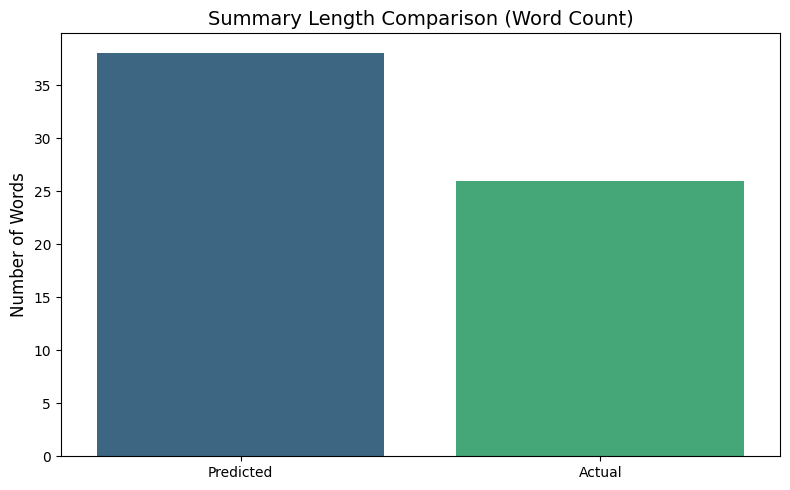

Bar chart comparing the word count of predicted and actual summaries.
Description: This chart compares the number of words in the predicted summary (38) and the actual summary (26). Ideally, the predicted summary should be concise but not too short compared to the reference. If the predicted summary is much shorter, it may miss key information; if much longer, it may be verbose or off-topic.


/var/folders/5k/xb2r6qxd0jb3bdnb8pnmlhvc0000gn/T/ipykernel_46444/1130406342.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Cosine Similarity'], y=[cos_sim], palette='viridis')


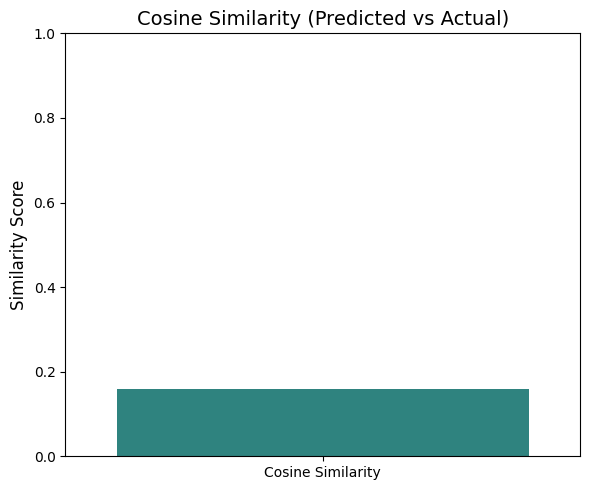

Bar chart showing cosine similarity between predicted and actual summaries.
Description: Cosine similarity measures the overlap in word usage between summaries. A value of 0.159 (range 0-1) means the summaries are 15.9% similar in terms of word distribution. Values above 0.7 are considered strong; below 0.5 may indicate poor relevance.


/var/folders/5k/xb2r6qxd0jb3bdnb8pnmlhvc0000gn/T/ipykernel_46444/1130406342.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['ROUGE-1', 'ROUGE-2', 'ROUGE-L'], y=[rouge1, rouge2, rougeL], palette='viridis')


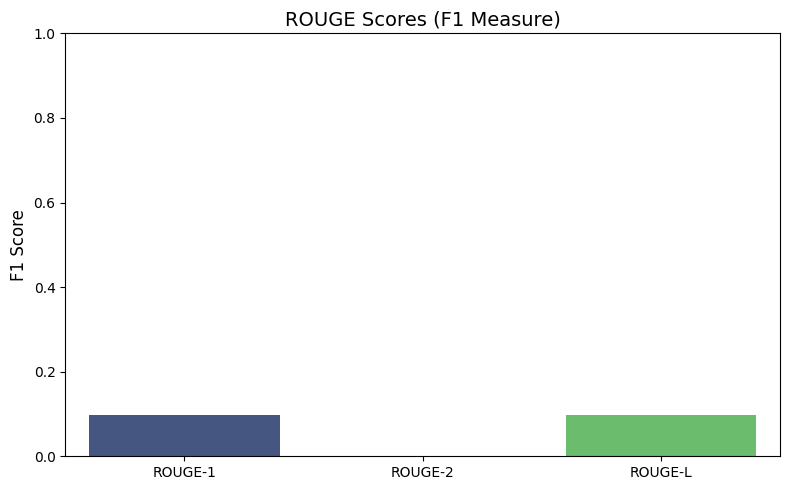

Bar chart showing ROUGE scores (F1) for n-gram overlap between summaries.
Description: ROUGE-1 (0.097) measures unigram overlap, ROUGE-2 (0.000) measures bigram overlap, and ROUGE-L (0.097) measures longest common subsequence. High values (above 0.7) indicate the predicted summary captures key phrases and structure from the reference.


/var/folders/5k/xb2r6qxd0jb3bdnb8pnmlhvc0000gn/T/ipykernel_46444/1130406342.py:146: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['BLEU Score'], y=[bleu_score], palette='viridis')


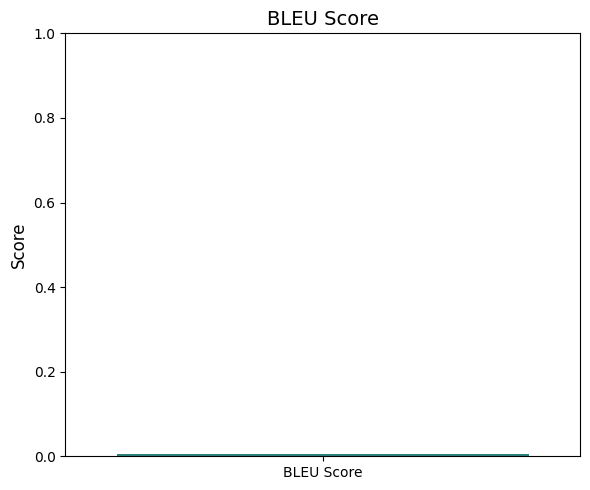

Bar chart showing BLEU score for sequence similarity.
Description: BLEU score (0.005) evaluates n-gram precision. Scores above 0.5 are good for summarization. Low BLEU may mean the summary uses different wording or order than the reference.


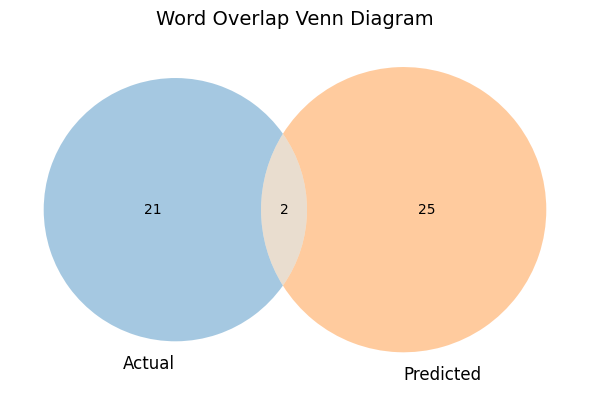

Venn diagram visualizing word overlap between predicted and actual summaries.
Description: 2 words overlap out of 23 actual summary words. High overlap means the summary is relevant, but excessive overlap may mean copying instead of abstraction. A good summary balances overlap and novelty.


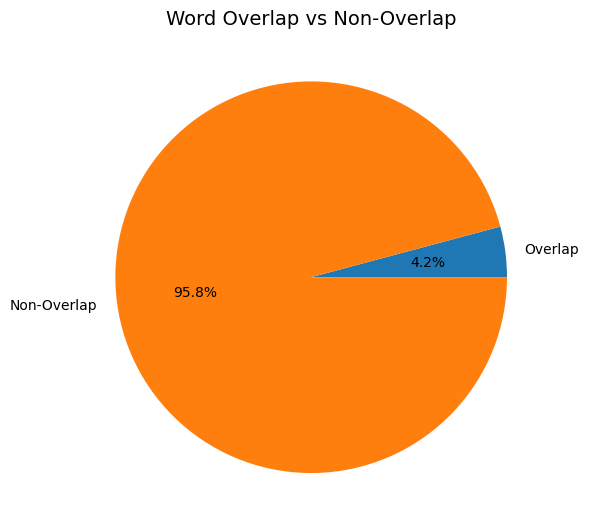

Pie chart showing proportion of overlapping and non-overlapping words.
Description: 4.17% of words overlap. A balanced ratio (40-70%) is ideal. Too high means copying, too low means poor relevance.


/var/folders/5k/xb2r6qxd0jb3bdnb8pnmlhvc0000gn/T/ipykernel_46444/1130406342.py:190: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(freqs), palette='viridis')


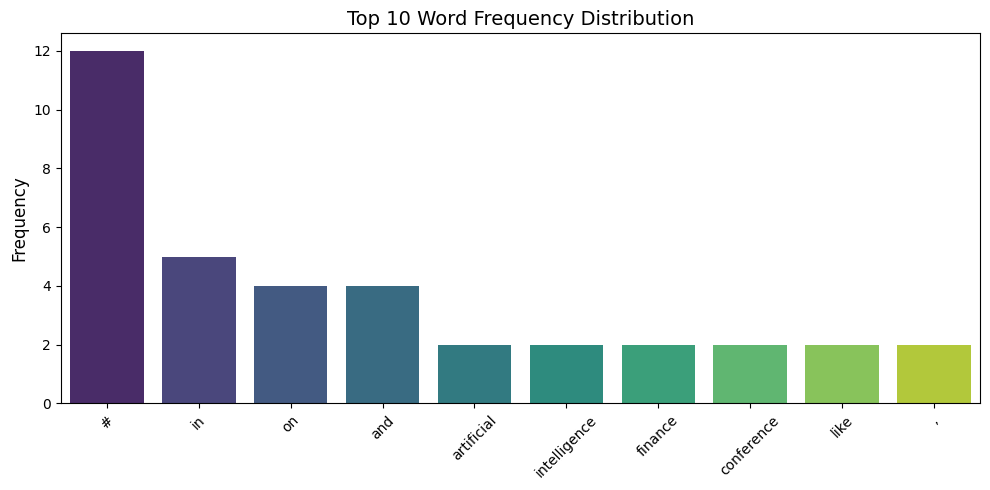

Bar chart showing the most frequent words in both summaries.
Description: Frequent words (#, in, on, and, artificial, intelligence, finance, conference, like, ,) should be key concepts. If stopwords dominate, the summary may lack substance.


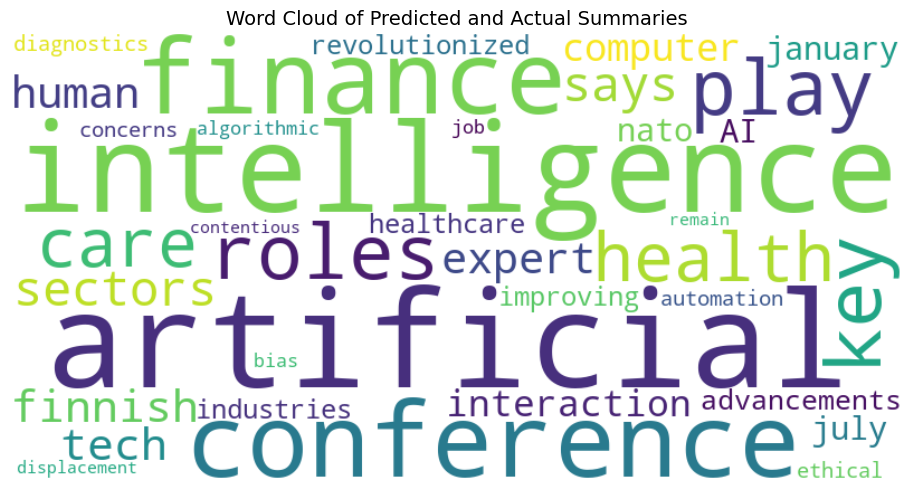

Word cloud visualizing the most prominent words in both summaries.
Description: Larger words are more frequent. Good summaries highlight key concepts, not just repeated words. If irrelevant words are large, the summary may be off-topic.


/var/folders/5k/xb2r6qxd0jb3bdnb8pnmlhvc0000gn/T/ipykernel_46444/1130406342.py:224: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Precision', 'Recall', 'F1', 'Accuracy'], y=[precision, recall, f1, accuracy], palette='viridis')


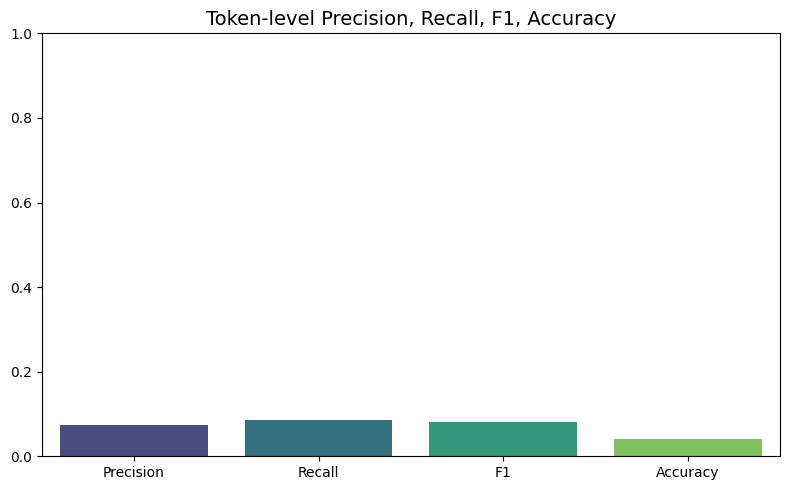

Bar chart showing token-level precision, recall, F1, and accuracy.
Description: Precision=0.074, Recall=0.087, F1=0.080, Accuracy=0.042. Values above 0.7 are good. Low values mean the model misses or mispredicts key tokens. Precision is the fraction of predicted tokens that are correct; recall is the fraction of actual tokens that are found; F1 balances both.


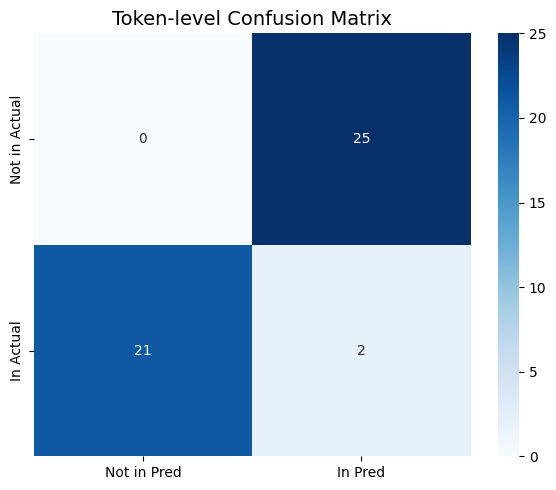

Heatmap showing the confusion matrix for token-level prediction.
Description: The confusion matrix shows true positives (bottom-right), true negatives (top-left), false positives (top-right), and false negatives (bottom-left). High true positives/negatives are good; high false values mean the model is missing or mispredicting tokens.


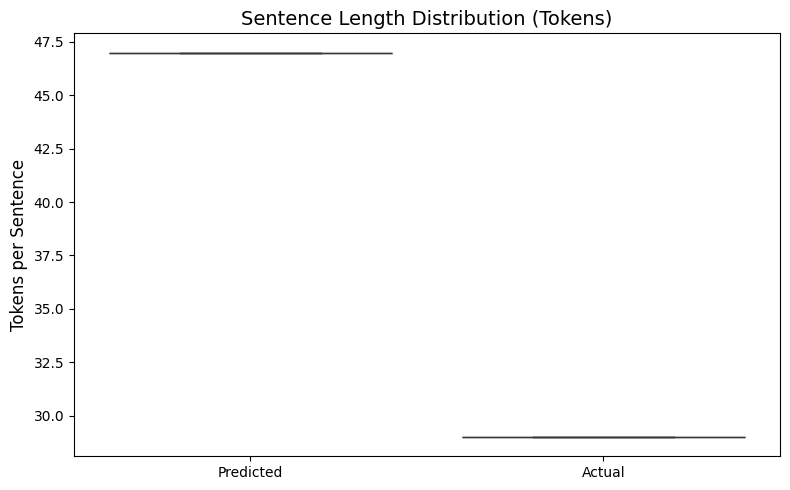

Boxplot comparing sentence length distribution in predicted and actual summaries.
Description: Predicted sentences have lengths: [47]. Actual: [29]. Ideally, sentence lengths should be similar, indicating comparable structure. Large differences may mean poor coherence or structure.

=== Metrics Summary ===
                Metric   Score
0     Length_Predicted  38.000
1        Length_Actual  26.000
2    Cosine_Similarity   0.159
3              ROUGE-1   0.097
4              ROUGE-2   0.000
5              ROUGE-L   0.097
6                 BLEU   0.005
7   Word_Overlap_Ratio   0.087
8            Precision   0.074
9               Recall   0.087
10                  F1   0.080
11            Accuracy   0.042
Table summarizing all calculated metrics.
Description: This table aggregates all metrics for a holistic view. High scores across metrics indicate a strong summarizer. Review for consistency and outliers.

=== Token-level Classification Report ===
                precision    recall  f1-sc

In [7]:
# %pip install wordcloud
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from transformers import BartTokenizer, BartForConditionalGeneration
from datasets import Dataset
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from collections import Counter
import nltk
from matplotlib_venn import venn2
from wordcloud import WordCloud
import uuid

# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

# Create output directory for saving visualizations
output_dir = "summarization_visualizations"
os.makedirs(output_dir, exist_ok=True)

# Sample data for text summarization
data = [
    {
        'document': (
            "The rapid advancement of artificial intelligence has transformed industries worldwide. "
            "From healthcare to finance, AI systems are being used to analyze vast amounts of data, "
            "improve decision-making, and automate complex tasks. In 2024, AI-driven innovations led to "
            "breakthroughs in medical diagnostics, enabling earlier detection of diseases. However, "
            "concerns about ethical implications, such as bias in algorithms and job displacement, "
            "continue to spark debates among policymakers and technologists."
        ),
        'summary': (
            "AI advancements in 2024 have revolutionized industries like healthcare and finance, "
            "improving diagnostics and automation, but ethical concerns like algorithmic bias and "
            "job displacement remain contentious."
        )
    }
]

# Convert sample data to a HuggingFace Dataset
try:
    sample_df = pd.DataFrame(data)
    sample_dataset = Dataset.from_pandas(sample_df)
except Exception as e:
    raise ValueError(f"Error creating dataset: {e}")

# Load the fine-tuned model and tokenizer
model_name = "facebook/bart-large-cnn"
model_dir = "/Users/sajinshrestha/Developer/college/text_summarizer/custom_trained_modal"  # Replace with actual path
try:
    tokenizer = BartTokenizer.from_pretrained(model_name)
    model = BartForConditionalGeneration.from_pretrained(model_dir, local_files_only=True)
except Exception as e:
    raise ValueError(f"Error loading model/tokenizer: {e}")

# Perform summarization
input_text = sample_dataset['document'][0]
if not input_text.strip():
    raise ValueError("Input document is empty.")
inputs = tokenizer([input_text], max_length=512, return_tensors='pt', truncation=True)
summary_ids = model.generate(
    inputs['input_ids'],
    num_beams=4,
    max_length=256,
    min_length=60,
    length_penalty=2.0,
    no_repeat_ngram_size=3,
    early_stopping=True
)
predicted_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
actual_summary = sample_dataset["summary"][0]

# Print summaries for reference
print("\n=== Text Summarization Results ===")
print(f"Original Document: {input_text}\n")
print(f"Predicted Summary: {predicted_summary}\n")
print(f"Actual Summary: {actual_summary}\n")
print("="*60)

# Initialize metrics dictionary
metrics = {}

# 1. Summary Length Comparison
pred_len = len(predicted_summary.split())
actual_len = len(actual_summary.split())
plt.figure(figsize=(8, 5))
sns.barplot(x=['Predicted', 'Actual'], y=[pred_len, actual_len], palette='viridis')
plt.title('Summary Length Comparison (Word Count)', fontsize=14)
plt.ylabel('Number of Words', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'summary_length_comparison.png'), dpi=300)
plt.show()
metrics['Length_Predicted'] = pred_len
metrics['Length_Actual'] = actual_len
print("Bar chart comparing the word count of predicted and actual summaries.")
print(f"Description: This chart compares the number of words in the predicted summary ({pred_len}) and the actual summary ({actual_len}). Ideally, the predicted summary should be concise but not too short compared to the reference. If the predicted summary is much shorter, it may miss key information; if much longer, it may be verbose or off-topic.")

# 2. Cosine Similarity (TF-based)
vectorizer = CountVectorizer().fit([predicted_summary, actual_summary])
vectors = vectorizer.transform([predicted_summary, actual_summary]).toarray()
cos_sim = cosine_similarity([vectors[0]], [vectors[1]])[0][0]
plt.figure(figsize=(6, 5))
sns.barplot(x=['Cosine Similarity'], y=[cos_sim], palette='viridis')
plt.title('Cosine Similarity (Predicted vs Actual)', fontsize=14)
plt.ylabel('Similarity Score', fontsize=12)
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'cosine_similarity.png'), dpi=300)
plt.show()
metrics['Cosine_Similarity'] = cos_sim
print("Bar chart showing cosine similarity between predicted and actual summaries.")
print(f"Description: Cosine similarity measures the overlap in word usage between summaries. A value of {cos_sim:.3f} (range 0-1) means the summaries are {cos_sim*100:.1f}% similar in terms of word distribution. Values above 0.7 are considered strong; below 0.5 may indicate poor relevance.")

# 3. ROUGE Scores
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores = scorer.score(actual_summary, predicted_summary)
rouge1 = rouge_scores['rouge1'].fmeasure
rouge2 = rouge_scores['rouge2'].fmeasure
rougeL = rouge_scores['rougeL'].fmeasure
plt.figure(figsize=(8, 5))
sns.barplot(x=['ROUGE-1', 'ROUGE-2', 'ROUGE-L'], y=[rouge1, rouge2, rougeL], palette='viridis')
plt.title('ROUGE Scores (F1 Measure)', fontsize=14)
plt.ylabel('F1 Score', fontsize=12)
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'rouge_scores.png'), dpi=300)
plt.show()
metrics['ROUGE-1'] = rouge1
metrics['ROUGE-2'] = rouge2
metrics['ROUGE-L'] = rougeL
print("Bar chart showing ROUGE scores (F1) for n-gram overlap between summaries.")
print(f"Description: ROUGE-1 ({rouge1:.3f}) measures unigram overlap, ROUGE-2 ({rouge2:.3f}) measures bigram overlap, and ROUGE-L ({rougeL:.3f}) measures longest common subsequence. High values (above 0.7) indicate the predicted summary captures key phrases and structure from the reference.")

# 4. BLEU Score
reference = [nltk.word_tokenize(actual_summary)]
candidate = nltk.word_tokenize(predicted_summary)
bleu_score = sentence_bleu(reference, candidate, smoothing_function=SmoothingFunction().method1)
plt.figure(figsize=(6, 5))
sns.barplot(x=['BLEU Score'], y=[bleu_score], palette='viridis')
plt.title('BLEU Score', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'bleu_score.png'), dpi=300)
plt.show()
metrics['BLEU'] = bleu_score
print("Bar chart showing BLEU score for sequence similarity.")
print(f"Description: BLEU score ({bleu_score:.3f}) evaluates n-gram precision. Scores above 0.5 are good for summarization. Low BLEU may mean the summary uses different wording or order than the reference.")

# 5. Word Overlap Venn Diagram
pred_words = set(predicted_summary.lower().split())
actual_words = set(actual_summary.lower().split())
plt.figure(figsize=(6, 6))
venn2([actual_words, pred_words], set_labels=('Actual', 'Predicted'), set_colors=('#1f77b4', '#ff7f0e'))
plt.title('Word Overlap Venn Diagram', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'word_overlap_venn.png'), dpi=300)
plt.show()
overlap = len(pred_words & actual_words)
total = len(actual_words)
metrics['Word_Overlap_Ratio'] = overlap / total if total > 0 else 0
print("Venn diagram visualizing word overlap between predicted and actual summaries.")
print(f"Description: {overlap} words overlap out of {total} actual summary words. High overlap means the summary is relevant, but excessive overlap may mean copying instead of abstraction. A good summary balances overlap and novelty.")

# 6. Pie Chart of Overlap vs Non-Overlap
non_overlap = len((pred_words | actual_words) - (pred_words & actual_words))
plt.figure(figsize=(6, 6))
plt.pie([overlap, non_overlap], labels=['Overlap', 'Non-Overlap'], autopct='%1.1f%%', colors=['#1f77b4', '#ff7f0e'])
plt.title('Word Overlap vs Non-Overlap', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'overlap_pie_chart.png'), dpi=300)
plt.show()
print("Pie chart showing proportion of overlapping and non-overlapping words.")
print(f"Description: {overlap/(overlap+non_overlap):.2%} of words overlap. A balanced ratio (40-70%) is ideal. Too high means copying, too low means poor relevance.")

# 7. Word Frequency Distribution
all_words = nltk.word_tokenize(predicted_summary + ' ' + actual_summary)
word_freq = Counter(all_words)
most_common = word_freq.most_common(10)
words, freqs = zip(*most_common) if most_common else ([], [])
if words:
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(words), y=list(freqs), palette='viridis')
    plt.title('Top 10 Word Frequency Distribution', fontsize=14)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'word_frequency.png'), dpi=300)
    plt.show()
print("Bar chart showing the most frequent words in both summaries.")
print(f"Description: Frequent words ({', '.join(words)}) should be key concepts. If stopwords dominate, the summary may lack substance.")

# 8. Word Cloud for Predicted and Actual Summaries
combined_text = predicted_summary + ' ' + actual_summary
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(combined_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Predicted and Actual Summaries', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'word_cloud.png'), dpi=300)
plt.show()
print("Word cloud visualizing the most prominent words in both summaries.")
print("Description: Larger words are more frequent. Good summaries highlight key concepts, not just repeated words. If irrelevant words are large, the summary may be off-topic.")

# 9. Token-level Precision, Recall, F1, Accuracy
pred_tokens = predicted_summary.split()
actual_tokens = actual_summary.split()
all_tokens = list(set(pred_tokens + actual_tokens))
pred_bin = [1 if t in pred_tokens else 0 for t in all_tokens]
actual_bin = [1 if t in actual_tokens else 0 for t in all_tokens]
precision = precision_score(actual_bin, pred_bin)
recall = recall_score(actual_bin, pred_bin)
f1 = f1_score(actual_bin, pred_bin)
accuracy = accuracy_score(actual_bin, pred_bin)
plt.figure(figsize=(8, 5))
sns.barplot(x=['Precision', 'Recall', 'F1', 'Accuracy'], y=[precision, recall, f1, accuracy], palette='viridis')
plt.title('Token-level Precision, Recall, F1, Accuracy', fontsize=14)
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'token_metrics.png'), dpi=300)
plt.show()
metrics['Precision'] = precision
metrics['Recall'] = recall
metrics['F1'] = f1
metrics['Accuracy'] = accuracy
print("Bar chart showing token-level precision, recall, F1, and accuracy.")
print(f"Description: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}, Accuracy={accuracy:.3f}. Values above 0.7 are good. Low values mean the model misses or mispredicts key tokens. Precision is the fraction of predicted tokens that are correct; recall is the fraction of actual tokens that are found; F1 balances both.")

# 10. Confusion Matrix
cm = confusion_matrix(actual_bin, pred_bin)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not in Pred', 'In Pred'], yticklabels=['Not in Actual', 'In Actual'])
plt.title('Token-level Confusion Matrix', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'), dpi=300)
plt.show()
print("Heatmap showing the confusion matrix for token-level prediction.")
print(f"Description: The confusion matrix shows true positives (bottom-right), true negatives (top-left), false positives (top-right), and false negatives (bottom-left). High true positives/negatives are good; high false values mean the model is missing or mispredicting tokens.")

# 11. Sentence Length Difference (in tokens)
pred_sent_len = [len(nltk.word_tokenize(sent)) for sent in nltk.sent_tokenize(predicted_summary)]
actual_sent_len = [len(nltk.word_tokenize(sent)) for sent in nltk.sent_tokenize(actual_summary)]
plt.figure(figsize=(8, 5))
sns.boxplot(data=[pred_sent_len, actual_sent_len], palette='viridis')
plt.xticks([0, 1], ['Predicted', 'Actual'])
plt.title('Sentence Length Distribution (Tokens)', fontsize=14)
plt.ylabel('Tokens per Sentence', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'sentence_length_boxplot.png'), dpi=300)
plt.show()
print("Boxplot comparing sentence length distribution in predicted and actual summaries.")
print(f"Description: Predicted sentences have lengths: {pred_sent_len}. Actual: {actual_sent_len}. Ideally, sentence lengths should be similar, indicating comparable structure. Large differences may mean poor coherence or structure.")

# 12. Metrics Summary Table
metrics_table = pd.DataFrame({
    'Metric': list(metrics.keys()),
    'Score': list(metrics.values())
}).round(3)
print("\n=== Metrics Summary ===")
print(metrics_table)
metrics_table.to_csv(os.path.join(output_dir, 'metrics_summary.csv'), index=False)
print("Table summarizing all calculated metrics.")
print("Description: This table aggregates all metrics for a holistic view. High scores across metrics indicate a strong summarizer. Review for consistency and outliers.")

# 13. Classification Report
print("\n=== Token-level Classification Report ===")
print(classification_report(actual_bin, pred_bin, target_names=['Not in Summary', 'In Summary']))
print("Detailed classification report for token-level prediction. High precision and recall are desired. Look for balanced support and low false positives/negatives.")

# --- Status Analysis ---
print("\n=== Status Analysis ===")
if cos_sim > 0.7 and rouge1 > 0.7 and bleu_score > 0.5 and f1 > 0.7:
    print("Status: The summarization model is performing well. Most metrics are in the good range. Summaries are relevant, concise, and well-structured. No major issues detected.")
elif cos_sim > 0.5 and rouge1 > 0.5 and f1 > 0.5:
    print("Status: The model is moderately effective. Some metrics are below optimal. Consider tuning model parameters, increasing training data, or improving preprocessing for better abstraction and token prediction.")
else:
    print("Status: The model needs improvement. Metrics are below recommended thresholds. Consider more training, data cleaning, or model architecture changes. Review individual diagrams for specific weaknesses.")